In [1]:
# import 
import pandas as  pd
import  numpy as  np
import  os
from pyspark.sql.functions import col, when,lit,udf
from pyspark.sql.types import StructType, StructField, StringType,IntegerType
import  warnings 
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
%matplotlib inline

#import pymysql
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Python Spark regression").config("config.option", "value").getOrCreate()
sc = spark.sparkContext


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/10 11:05:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# load greenhouse.csv
greenhouse =spark.read.csv(path='./data/greenhouse.csv',encoding='UTF-8',comment=None, header=True,inferSchema=True)
greenhouse.show(20)

+---------+----+--------------+--------------------+
|  country|year|greengas_value|            category|
+---------+----+--------------+--------------------+
|Australia|2014|    393126.947|carbon_dioxide_co...|
|Australia|2013|   396913.9365|carbon_dioxide_co...|
|Australia|2012|   406462.8477|carbon_dioxide_co...|
|Australia|2011|   403705.5283|carbon_dioxide_co...|
|Australia|2010|   406200.9932|carbon_dioxide_co...|
|Australia|2009|    408448.479|carbon_dioxide_co...|
|Australia|2008|   404237.8282|carbon_dioxide_co...|
|Australia|2007|   398816.4535|carbon_dioxide_co...|
|Australia|2006|   391134.1009|carbon_dioxide_co...|
|Australia|2005|   385581.1328|carbon_dioxide_co...|
|Australia|2004|   381519.2616|carbon_dioxide_co...|
|Australia|2003|   368345.9774|carbon_dioxide_co...|
|Australia|2002|   361861.3879|carbon_dioxide_co...|
|Australia|2001|   357653.3299|carbon_dioxide_co...|
|Australia|2000|   349885.4331|carbon_dioxide_co...|
|Australia|1999|   343713.9069|carbon_dioxide_

In [3]:
type(greenhouse)

pyspark.sql.dataframe.DataFrame

In [4]:

print(greenhouse.dtypes)


[('country', 'string'), ('year', 'int'), ('greengas_value', 'double'), ('category', 'string')]


In [5]:

greenhouse.count()

8406

<AxesSubplot:xlabel='year', ylabel='greengas_value'>

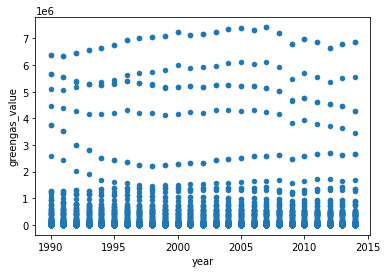

In [6]:
greenhouse.toPandas().plot.scatter(x="year",y="greengas_value")

In [7]:
greenhouse.describe().show()

+-------+--------------------+------------------+------------------+--------------------+
|summary|             country|              year|    greengas_value|            category|
+-------+--------------------+------------------+------------------+--------------------+
|  count|                8406|              8406|              8406|                8406|
|   mean|                null|2002.1884368308351|205547.19137139976|                null|
| stddev|                null| 7.151604788310116|  804150.377036362|                null|
|    min|           Australia|              1990|            1.1E-6|carbon_dioxide_co...|
|    max|United States of ...|              2014|       7422207.963|unspecified_mix_o...|
+-------+--------------------+------------------+------------------+--------------------+



In [8]:
# load yd.csv
yd =spark.read.csv(path='./data/yd.csv',encoding='UTF-8',comment=None, header=True,inferSchema=True)
yd.show(20)

+-----------+------+------------+-----------+------------+-------+---------+-----+---------+----+-----+-----------+
|Domain Code|Domain|Country Code|    country|Element Code|Element|Item Code| Item|Year Code|year| Unit|Yield Value|
+-----------+------+------------+-----------+------------+-------+---------+-----+---------+----+-----+-----------+
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1961|1961|hg/ha|      14000|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1962|1962|hg/ha|      14000|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1963|1963|hg/ha|      14260|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1964|1964|hg/ha|      14257|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1965|1965|hg/ha|      14400|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|      

In [9]:
type(yd)

pyspark.sql.dataframe.DataFrame

In [10]:

print(yd.dtypes)


[('Domain Code', 'string'), ('Domain', 'string'), ('Country Code', 'int'), ('country', 'string'), ('Element Code', 'int'), ('Element', 'string'), ('Item Code', 'int'), ('Item', 'string'), ('Year Code', 'int'), ('year', 'int'), ('Unit', 'string'), ('Yield Value', 'int')]


In [11]:

yd.count()

56717

<AxesSubplot:xlabel='year', ylabel='Yield Value'>

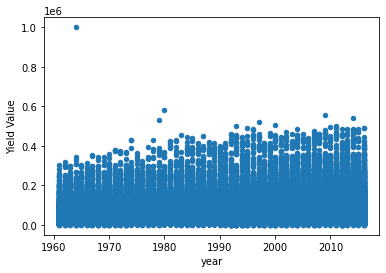

In [12]:
yd.toPandas().plot.scatter(x="year",y="Yield Value")

In [13]:
yd.describe().show()

+-------+-----------+------+------------------+--------------+------------+-------+------------------+-------+-----------------+-----------------+-----+-----------------+
|summary|Domain Code|Domain|      Country Code|       country|Element Code|Element|         Item Code|   Item|        Year Code|             year| Unit|      Yield Value|
+-------+-----------+------+------------------+--------------+------------+-------+------------------+-------+-----------------+-----------------+-----+-----------------+
|  count|      56717| 56717|             56717|         56717|       56717|  56717|             56717|  56717|            56717|            56717|56717|            56717|
|   mean|       null|  null|125.65042227198195|          null|      5419.0|   null|111.61165082779414|   null|1989.669569970203|1989.669569970203| null|62094.66008427808|
| stddev|       null|  null| 75.12019495452651|          null|         0.0|   null|101.27843534146328|   null|16.13319773965858|16.13319773965858

In [14]:
# load temp.csv
temp =spark.read.csv(path='./data/temp.csv',encoding='UTF-8',comment=None, header=True,inferSchema=True)
temp.show(20)

+----+--------------+--------+
|year|       country|avg_temp|
+----+--------------+--------+
|1849| cote d ivoire|   25.58|
|1850| cote d ivoire|   25.52|
|1851| cote d ivoire|   25.67|
|1852| cote d ivoire|    null|
|1853| cote d ivoire|    null|
|1854| cote d ivoire|    null|
|1855| cote d ivoire|    null|
|1856| cote d ivoire|   26.28|
|1857| cote d ivoire|   25.17|
|1858| cote d ivoire|   25.49|
|1859| cote d ivoire|   25.92|
|1860| cote d ivoire|   25.46|
|1861| cote d ivoire|   25.67|
|1862| cote d ivoire|   25.17|
|1863| cote d ivoire|    null|
|1864| cote d ivoire|    null|
|1865| cote d ivoire|    null|
|1866| cote d ivoire|    null|
|1867| cote d ivoire|    null|
|1868| cote d ivoire|    null|
+----+--------------+--------+
only showing top 20 rows



In [15]:
type(temp)

pyspark.sql.dataframe.DataFrame

In [16]:

print(temp.dtypes)

[('year', 'int'), ('country', 'string'), ('avg_temp', 'double')]


In [17]:

temp.count()

71311

<AxesSubplot:xlabel='year', ylabel='avg_temp'>

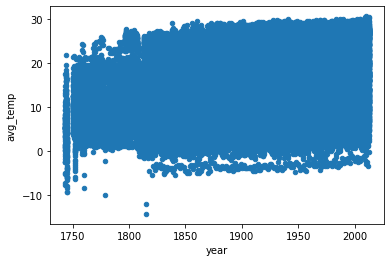

In [18]:
temp.toPandas().plot.scatter(x="year",y="avg_temp")

In [19]:
temp.describe().show()

+-------+------------------+--------------+------------------+
|summary|              year|       country|          avg_temp|
+-------+------------------+--------------+------------------+
|  count|             71311|         71311|             68764|
|   mean|1905.7990071657948|          null|16.183876010703003|
| stddev| 67.10209855498213|          null|  7.59295961246696|
|    min|              1743| cote d ivoire|            -14.35|
|    max|              2013|      Zimbabwe|             30.73|
+-------+------------------+--------------+------------------+



In [20]:
# load rainfall.csv
rainfall =spark.read.csv(path='./data/rainfall.csv',encoding='UTF-8',comment=None, header=True,inferSchema=True)
rainfall.show(20)

+-----------+----+-----------------------------+
|    country|year|average_rain_fall_mm_per_year|
+-----------+----+-----------------------------+
|Afghanistan|1985|                          327|
|Afghanistan|1986|                          327|
|Afghanistan|1987|                          327|
|Afghanistan|1989|                          327|
|Afghanistan|1990|                          327|
|Afghanistan|1991|                          327|
|Afghanistan|1992|                          327|
|Afghanistan|1993|                          327|
|Afghanistan|1994|                          327|
|Afghanistan|1995|                          327|
|Afghanistan|1996|                          327|
|Afghanistan|1997|                          327|
|Afghanistan|1998|                          327|
|Afghanistan|1999|                          327|
|Afghanistan|2000|                          327|
|Afghanistan|2001|                          327|
|Afghanistan|2002|                          327|
|Afghanistan|2004|  

In [21]:
type(rainfall)

pyspark.sql.dataframe.DataFrame

In [22]:

print(rainfall.dtypes)

[('country', 'string'), ('year', 'int'), ('average_rain_fall_mm_per_year', 'string')]


In [23]:

rainfall.count()

6727

In [23]:
rainfall.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- average_rain_fall_mm_per_year: string (nullable = true)



In [90]:
rainfall = rainfall.withColumn("average_rain_fall_mm_per_year", rainfall.average_rain_fall_mm_per_year.cast("int"))

In [91]:
rainfall.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- average_rain_fall_mm_per_year: integer (nullable = true)



<AxesSubplot:xlabel='year', ylabel='average_rain_fall_mm_per_year'>

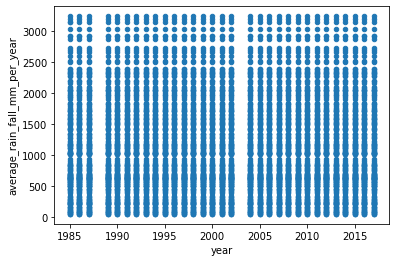

In [92]:
rainfall.toPandas().plot.scatter(x="year",y="average_rain_fall_mm_per_year")

In [24]:
rainfall.describe().show()

+-------+-----------+------------------+-----------------------------+
|summary|    country|              year|average_rain_fall_mm_per_year|
+-------+-----------+------------------+-----------------------------+
|  count|       6727|              6727|                         5948|
|   mean|       null|2001.3548387096773|           1124.7432318816209|
| stddev|       null| 9.530114093532259|            786.2573647424136|
|    min|Afghanistan|              1985|                             |
|    max|   Zimbabwe|              2017|                          934|
+-------+-----------+------------------+-----------------------------+



In [25]:
# 创建一个临时表
yd.createOrReplaceTempView("ydtable")

In [26]:
Yield_Value=yd.select("Yield Value").collect()
Yield_Value

[Row(Yield Value=14000),
 Row(Yield Value=14000),
 Row(Yield Value=14260),
 Row(Yield Value=14257),
 Row(Yield Value=14400),
 Row(Yield Value=14400),
 Row(Yield Value=14144),
 Row(Yield Value=17064),
 Row(Yield Value=17177),
 Row(Yield Value=14757),
 Row(Yield Value=13400),
 Row(Yield Value=15652),
 Row(Yield Value=16170),
 Row(Yield Value=16170),
 Row(Yield Value=16116),
 Row(Yield Value=16598),
 Row(Yield Value=15833),
 Row(Yield Value=16183),
 Row(Yield Value=16102),
 Row(Yield Value=16711),
 Row(Yield Value=16690),
 Row(Yield Value=16658),
 Row(Yield Value=16641),
 Row(Yield Value=16612),
 Row(Yield Value=16652),
 Row(Yield Value=16875),
 Row(Yield Value=17020),
 Row(Yield Value=17034),
 Row(Yield Value=16963),
 Row(Yield Value=17582),
 Row(Yield Value=16800),
 Row(Yield Value=15000),
 Row(Yield Value=16786),
 Row(Yield Value=16667),
 Row(Yield Value=16563),
 Row(Yield Value=16364),
 Row(Yield Value=15000),
 Row(Yield Value=16500),
 Row(Yield Value=15000),
 Row(Yield Value=11979),


(array([4.4863e+04, 8.9430e+03, 2.1550e+03, 5.5100e+02, 1.9700e+02,
        7.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([      0.,  100000.,  200000.,  300000.,  400000.,  500000.,
         600000.,  700000.,  800000.,  900000., 1000000.]),
 <BarContainer object of 10 artists>)

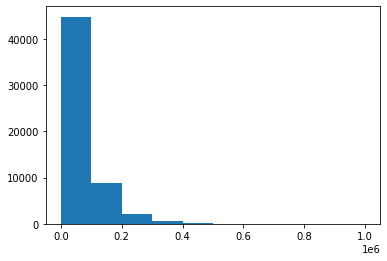

In [71]:
plt.hist(yd.toPandas()["Yield Value"])

In [27]:
# Find the missing data in each row
yd.rdd.map(lambda row: (row['Domain Code'], sum([c == None for c in row]))).collect()


[('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('QC', 0),
 ('Q

In [28]:
# Look at the proportion of missing values
import pyspark.sql.functions as fn

yd.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in yd.columns]).show()

+-------------------+--------------+--------------------+---------------+--------------------+---------------+-----------------+------------+-----------------+------------+------------+-------------------+
|Domain Code missing|Domain missing|Country Code missing|country missing|Element Code missing|Element missing|Item Code missing|Item missing|Year Code missing|year missing|Unit missing|Yield Value missing|
+-------------------+--------------+--------------------+---------------+--------------------+---------------+-----------------+------------+-----------------+------------+------------+-------------------+
|                0.0|           0.0|                 0.0|            0.0|                 0.0|            0.0|              0.0|         0.0|              0.0|         0.0|         0.0|                0.0|
+-------------------+--------------+--------------------+---------------+--------------------+---------------+-----------------+------------+-----------------+------------+----

In [29]:

temp.rdd.map(lambda row: (row['year'], sum([c == None for c in row]))).collect()

[(1849, 0),
 (1850, 0),
 (1851, 0),
 (1852, 1),
 (1853, 1),
 (1854, 1),
 (1855, 1),
 (1856, 0),
 (1857, 0),
 (1858, 0),
 (1859, 0),
 (1860, 0),
 (1861, 0),
 (1862, 0),
 (1863, 1),
 (1864, 1),
 (1865, 1),
 (1866, 1),
 (1867, 1),
 (1868, 1),
 (1869, 1),
 (1870, 1),
 (1871, 1),
 (1872, 1),
 (1873, 0),
 (1874, 0),
 (1875, 0),
 (1876, 0),
 (1877, 0),
 (1878, 0),
 (1879, 0),
 (1880, 0),
 (1881, 0),
 (1882, 0),
 (1883, 0),
 (1884, 0),
 (1885, 0),
 (1886, 0),
 (1887, 0),
 (1888, 0),
 (1889, 0),
 (1890, 0),
 (1891, 0),
 (1892, 0),
 (1893, 0),
 (1894, 0),
 (1895, 0),
 (1896, 0),
 (1897, 0),
 (1898, 0),
 (1899, 0),
 (1900, 0),
 (1901, 0),
 (1902, 0),
 (1903, 0),
 (1904, 0),
 (1905, 0),
 (1906, 0),
 (1907, 0),
 (1908, 0),
 (1909, 0),
 (1910, 0),
 (1911, 0),
 (1912, 0),
 (1913, 0),
 (1914, 0),
 (1915, 0),
 (1916, 0),
 (1917, 0),
 (1918, 0),
 (1919, 0),
 (1920, 0),
 (1921, 0),
 (1922, 0),
 (1923, 0),
 (1924, 0),
 (1925, 0),
 (1926, 0),
 (1927, 0),
 (1928, 0),
 (1929, 0),
 (1930, 0),
 (1931, 0),
 (19

In [30]:

import pyspark.sql.functions as fn

temp.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in temp.columns]).show()

+------------+---------------+--------------------+
|year missing|country missing|    avg_temp missing|
+------------+---------------+--------------------+
|         0.0|            0.0|0.035716789836070184|
+------------+---------------+--------------------+



In [31]:

temp=temp.fillna(0)
temp.show()

+----+--------------+--------+
|year|       country|avg_temp|
+----+--------------+--------+
|1849| cote d ivoire|   25.58|
|1850| cote d ivoire|   25.52|
|1851| cote d ivoire|   25.67|
|1852| cote d ivoire|     0.0|
|1853| cote d ivoire|     0.0|
|1854| cote d ivoire|     0.0|
|1855| cote d ivoire|     0.0|
|1856| cote d ivoire|   26.28|
|1857| cote d ivoire|   25.17|
|1858| cote d ivoire|   25.49|
|1859| cote d ivoire|   25.92|
|1860| cote d ivoire|   25.46|
|1861| cote d ivoire|   25.67|
|1862| cote d ivoire|   25.17|
|1863| cote d ivoire|     0.0|
|1864| cote d ivoire|     0.0|
|1865| cote d ivoire|     0.0|
|1866| cote d ivoire|     0.0|
|1867| cote d ivoire|     0.0|
|1868| cote d ivoire|     0.0|
+----+--------------+--------+
only showing top 20 rows



In [32]:

temp.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in temp.columns]).show()

+------------+---------------+----------------+
|year missing|country missing|avg_temp missing|
+------------+---------------+----------------+
|         0.0|            0.0|             0.0|
+------------+---------------+----------------+



In [33]:


rainfall.rdd.map(lambda row: (row['country'], sum([c == None for c in row]))).collect()

[('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Afghanistan', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albania', 0),
 ('Albani

In [79]:

import pyspark.sql.functions as fn

rainfall.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in rainfall.columns]).show()

+---------------+------------+-------------------------------------+
|country missing|year missing|average_rain_fall_mm_per_year missing|
+---------------+------------+-------------------------------------+
|            0.0|         0.0|                  0.11580199197264751|
+---------------+------------+-------------------------------------+



In [41]:

rainfall=rainfall.fillna(int("0"))
rainfall.show(1000)


+--------------------+----+-----------------------------+
|             country|year|average_rain_fall_mm_per_year|
+--------------------+----+-----------------------------+
|         Afghanistan|1985|                          327|
|         Afghanistan|1986|                          327|
|         Afghanistan|1987|                          327|
|         Afghanistan|1989|                          327|
|         Afghanistan|1990|                          327|
|         Afghanistan|1991|                          327|
|         Afghanistan|1992|                          327|
|         Afghanistan|1993|                          327|
|         Afghanistan|1994|                          327|
|         Afghanistan|1995|                          327|
|         Afghanistan|1996|                          327|
|         Afghanistan|1997|                          327|
|         Afghanistan|1998|                          327|
|         Afghanistan|1999|                          327|
|         Afgh

In [42]:

import pyspark.sql.functions as fn

rainfall.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in rainfall.columns]).show()

+---------------+------------+-------------------------------------+
|country missing|year missing|average_rain_fall_mm_per_year missing|
+---------------+------------+-------------------------------------+
|            0.0|         0.0|                  0.11580199197264751|
+---------------+------------+-------------------------------------+



In [43]:

greenhouse.rdd.map(lambda row: (row['country'], sum([c == None for c in row]))).collect()

[('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Australia', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Austria', 0),
 ('Belarus', 0),
 ('Belarus', 0),
 ('Belarus', 0),
 ('Belarus', 0),
 ('Belarus', 0),
 ('Belarus', 0)

In [44]:

import pyspark.sql.functions as fn

greenhouse.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in greenhouse.columns]).show()

+---------------+------------+----------------------+----------------+
|country missing|year missing|greengas_value missing|category missing|
+---------------+------------+----------------------+----------------+
|            0.0|         0.0|                   0.0|             0.0|
+---------------+------------+----------------------+----------------+



1.greenhouse数据预处理

In [45]:

greenhouse.createOrReplaceTempView("greenhouseTable")

In [46]:
from pyspark.sql.functions import concat
greenhouse_new=greenhouse.withColumn('key1', concat(greenhouse.country,greenhouse.year))
greenhouse_new.show()

+---------+----+--------------+--------------------+-------------+
|  country|year|greengas_value|            category|         key1|
+---------+----+--------------+--------------------+-------------+
|Australia|2014|    393126.947|carbon_dioxide_co...|Australia2014|
|Australia|2013|   396913.9365|carbon_dioxide_co...|Australia2013|
|Australia|2012|   406462.8477|carbon_dioxide_co...|Australia2012|
|Australia|2011|   403705.5283|carbon_dioxide_co...|Australia2011|
|Australia|2010|   406200.9932|carbon_dioxide_co...|Australia2010|
|Australia|2009|    408448.479|carbon_dioxide_co...|Australia2009|
|Australia|2008|   404237.8282|carbon_dioxide_co...|Australia2008|
|Australia|2007|   398816.4535|carbon_dioxide_co...|Australia2007|
|Australia|2006|   391134.1009|carbon_dioxide_co...|Australia2006|
|Australia|2005|   385581.1328|carbon_dioxide_co...|Australia2005|
|Australia|2004|   381519.2616|carbon_dioxide_co...|Australia2004|
|Australia|2003|   368345.9774|carbon_dioxide_co...|Australia2

In [47]:

print('data volume [before] full field de-duplication {}'.format(int(greenhouse_new.count())))

greenhouse_new.dropDuplicates().count()
print('data volume [after] full field de-duplication {}'.format(int(greenhouse_new.count())))

data volume [before] full field de-duplication 8406
data volume [after] full field de-duplication 8406


In [48]:

greenhouse_new.dropDuplicates().count()

8406

In [49]:
dict_gh={ i:'type'+ str(j+1)  for j,i  in enumerate(set(greenhouse_new.select("category").collect())) }
dict_gh

{Row(category='greenhouse_gas_ghgs_emissions_including_indirect_co2_without_lulucf_in_kilotonne_co2_equivalent'): 'type1',
 Row(category='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'): 'type2',
 Row(category='nitrogen_trifluoride_nf3_emissions_in_kilotonne_co2_equivalent'): 'type3',
 Row(category='sulphur_hexafluoride_sf6_emissions_in_kilotonne_co2_equivalent'): 'type4',
 Row(category='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'): 'type5',
 Row(category='unspecified_mix_of_hydrofluorocarbons_hfcs_and_perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent'): 'type6',
 Row(category='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'): 'type7',
 Row(category='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'): 'type8',
 Row(category='greenhouse_gas_ghgs_emissions_without_land_use_land_use_

In [50]:
for key in dict_gh:
    keya=str(key).split("=")[1].split(")")[0]
    if  keya:
        print(dict_gh[key])
    

type1
type2
type3
type4
type5
type6
type7
type8
type9
type10


In [51]:
def fc(a):
    if a=="carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent":
        return "type1"
    elif a=="greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent":
        return "type2"
    elif a=="methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent":
        return "type3"
    elif a=="nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent":
        return "type4"
    elif a=="sulphur_hexafluoride_sf6_emissions_in_kilotonne_co2_equivalent":
        return "type5"
    elif a=="hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent":
        return "type6"
    elif a=="greenhouse_gas_ghgs_emissions_including_indirect_co2_without_lulucf_in_kilotonne_co2_equivalent":
        return "type7"
    elif a=="perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent":
        return "type8"
    elif a=="nitrogen_trifluoride_nf3_emissions_in_kilotonne_co2_equivalent":
        return "type9"
    else:
        return "type10"

fc = udf(fc, StringType())
greenhouse_new = greenhouse_new.withColumn('category_new', fc('category'))
greenhouse_new.show(10000)

+--------------------+----+--------------+--------------------+--------------------+------------+
|             country|year|greengas_value|            category|                key1|category_new|
+--------------------+----+--------------+--------------------+--------------------+------------+
|           Australia|2014|    393126.947|carbon_dioxide_co...|       Australia2014|       type1|
|           Australia|2013|   396913.9365|carbon_dioxide_co...|       Australia2013|       type1|
|           Australia|2012|   406462.8477|carbon_dioxide_co...|       Australia2012|       type1|
|           Australia|2011|   403705.5283|carbon_dioxide_co...|       Australia2011|       type1|
|           Australia|2010|   406200.9932|carbon_dioxide_co...|       Australia2010|       type1|
|           Australia|2009|    408448.479|carbon_dioxide_co...|       Australia2009|       type1|
|           Australia|2008|   404237.8282|carbon_dioxide_co...|       Australia2008|       type1|
|           Australi

In [53]:
gh=greenhouse_new.toPandas().pivot_table(values='greengas_value',columns=['category_new'],index=['key1'])
gh.reset_index(inplace=True)  

#gh

In [55]:

values =gh.values.tolist()
columns = gh.columns.tolist()
gh100= spark.createDataFrame(values, columns)

gh100.show()

+-------------+-----------+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+
|         key1|      type1|type10|      type2|      type3|      type4|      type5|      type6|      type7|      type8|type9|
+-------------+-----------+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+
|Australia1990|278265.8989|   NaN|418623.0496|118768.8378|15345.59786|211.0185114| 1424.68352|418623.0496|4607.012919|  NaN|
|Australia1991| 279741.639|   NaN|418674.0575|117744.6418|14923.40502|228.9448336| 1424.68352|418674.0575|4610.743294|  NaN|
|Australia1992|284766.0927|   NaN|423080.1082|116837.5067|15293.18335|246.8588488|   1333.184|423080.1082|4603.282544|  NaN|
|Australia1993|289142.2677|   NaN|423764.9326|113837.5119|15374.99343|264.7591563|   1829.872|423764.9326|3315.528376|  NaN|
|Australia1994|293830.7091|   NaN|424092.9594|110997.4102|15790.42685|282.6408961|1027.343549|424092.9594|2164.428749|  NaN|


In [60]:
gh['key1'].count()   

1074

②rainfall数据预处理

In [61]:
rainfall.show()

+-----------+----+-----------------------------+
|    country|year|average_rain_fall_mm_per_year|
+-----------+----+-----------------------------+
|Afghanistan|1985|                          327|
|Afghanistan|1986|                          327|
|Afghanistan|1987|                          327|
|Afghanistan|1989|                          327|
|Afghanistan|1990|                          327|
|Afghanistan|1991|                          327|
|Afghanistan|1992|                          327|
|Afghanistan|1993|                          327|
|Afghanistan|1994|                          327|
|Afghanistan|1995|                          327|
|Afghanistan|1996|                          327|
|Afghanistan|1997|                          327|
|Afghanistan|1998|                          327|
|Afghanistan|1999|                          327|
|Afghanistan|2000|                          327|
|Afghanistan|2001|                          327|
|Afghanistan|2002|                          327|
|Afghanistan|2004|  

In [62]:
from pyspark.sql.functions import concat
rainfall_new=rainfall.withColumn('key2', concat(rainfall.country,rainfall.year))
rainfall_new.show()

+-----------+----+-----------------------------+---------------+
|    country|year|average_rain_fall_mm_per_year|           key2|
+-----------+----+-----------------------------+---------------+
|Afghanistan|1985|                          327|Afghanistan1985|
|Afghanistan|1986|                          327|Afghanistan1986|
|Afghanistan|1987|                          327|Afghanistan1987|
|Afghanistan|1989|                          327|Afghanistan1989|
|Afghanistan|1990|                          327|Afghanistan1990|
|Afghanistan|1991|                          327|Afghanistan1991|
|Afghanistan|1992|                          327|Afghanistan1992|
|Afghanistan|1993|                          327|Afghanistan1993|
|Afghanistan|1994|                          327|Afghanistan1994|
|Afghanistan|1995|                          327|Afghanistan1995|
|Afghanistan|1996|                          327|Afghanistan1996|
|Afghanistan|1997|                          327|Afghanistan1997|
|Afghanistan|1998|       

In [63]:


print('data volume [before] full field de-duplication {}'.format(int(rainfall_new.count())))
rainfall_new=rainfall_new.distinct()
print('data volume [after] full field de-duplication {}'.format(int(rainfall_new.count())))

data volume [before] full field de-duplication 6727
data volume [after] full field de-duplication 6727


③temp 数据预处理

In [64]:
temp.show()

+----+--------------+--------+
|year|       country|avg_temp|
+----+--------------+--------+
|1849| cote d ivoire|   25.58|
|1850| cote d ivoire|   25.52|
|1851| cote d ivoire|   25.67|
|1852| cote d ivoire|     0.0|
|1853| cote d ivoire|     0.0|
|1854| cote d ivoire|     0.0|
|1855| cote d ivoire|     0.0|
|1856| cote d ivoire|   26.28|
|1857| cote d ivoire|   25.17|
|1858| cote d ivoire|   25.49|
|1859| cote d ivoire|   25.92|
|1860| cote d ivoire|   25.46|
|1861| cote d ivoire|   25.67|
|1862| cote d ivoire|   25.17|
|1863| cote d ivoire|     0.0|
|1864| cote d ivoire|     0.0|
|1865| cote d ivoire|     0.0|
|1866| cote d ivoire|     0.0|
|1867| cote d ivoire|     0.0|
|1868| cote d ivoire|     0.0|
+----+--------------+--------+
only showing top 20 rows



In [65]:
from pyspark.sql.functions import concat
temp_new=temp.withColumn('key3', concat(temp.country,temp.year))
temp_new.show()

+----+--------------+--------+------------------+
|year|       country|avg_temp|              key3|
+----+--------------+--------+------------------+
|1849| cote d ivoire|   25.58| cote d ivoire1849|
|1850| cote d ivoire|   25.52| cote d ivoire1850|
|1851| cote d ivoire|   25.67| cote d ivoire1851|
|1852| cote d ivoire|     0.0| cote d ivoire1852|
|1853| cote d ivoire|     0.0| cote d ivoire1853|
|1854| cote d ivoire|     0.0| cote d ivoire1854|
|1855| cote d ivoire|     0.0| cote d ivoire1855|
|1856| cote d ivoire|   26.28| cote d ivoire1856|
|1857| cote d ivoire|   25.17| cote d ivoire1857|
|1858| cote d ivoire|   25.49| cote d ivoire1858|
|1859| cote d ivoire|   25.92| cote d ivoire1859|
|1860| cote d ivoire|   25.46| cote d ivoire1860|
|1861| cote d ivoire|   25.67| cote d ivoire1861|
|1862| cote d ivoire|   25.17| cote d ivoire1862|
|1863| cote d ivoire|     0.0| cote d ivoire1863|
|1864| cote d ivoire|     0.0| cote d ivoire1864|
|1865| cote d ivoire|     0.0| cote d ivoire1865|


In [66]:

print('data volume [before] full field de-duplication {}'.format(int(temp_new.count())))
temp_new=temp_new.distinct()
temp_new.count()
print('data volume [after] full field de-duplication {}'.format(int(temp_new.count())))

data volume [before] full field de-duplication 71311
data volume [after] full field de-duplication 64361


In [67]:

temp_new_1=temp_new.toPandas().drop_duplicates(subset='key3', keep='first', inplace= False)
temp_new_1

,year,country,avg_temp,key3
0,1916,Nigeria,25.92,Nigeria1916
1,1852,Turkey,18.51,Turkey1852
2,1972,Turkey,18.38,Turkey1972
3,1894,India,24.89,India1894
4,1802,India,27.01,India1802
...,...,...,...,...
64341,1882,Tunisia,18.02,Tunisia1882
64343,1892,Mongolia,-4.54,Mongolia1892
64348,1894,Austria,7.99,Austria1894
64349,1939,Austria,8.49,Austria1939


④yeild 数据预处理

In [68]:
yd.show()

+-----------+------+------------+-----------+------------+-------+---------+-----+---------+----+-----+-----------+
|Domain Code|Domain|Country Code|    country|Element Code|Element|Item Code| Item|Year Code|year| Unit|Yield Value|
+-----------+------+------------+-----------+------------+-------+---------+-----+---------+----+-----+-----------+
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1961|1961|hg/ha|      14000|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1962|1962|hg/ha|      14000|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1963|1963|hg/ha|      14260|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1964|1964|hg/ha|      14257|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1965|1965|hg/ha|      14400|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|      

In [69]:
from pyspark.sql.functions import concat
yd_new=yd.withColumn('key4', concat(yd.country,yd.year))
yd_new.show()

+-----------+------+------------+-----------+------------+-------+---------+-----+---------+----+-----+-----------+---------------+
|Domain Code|Domain|Country Code|    country|Element Code|Element|Item Code| Item|Year Code|year| Unit|Yield Value|           key4|
+-----------+------+------------+-----------+------------+-------+---------+-----+---------+----+-----+-----------+---------------+
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1961|1961|hg/ha|      14000|Afghanistan1961|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1962|1962|hg/ha|      14000|Afghanistan1962|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1963|1963|hg/ha|      14260|Afghanistan1963|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|Maize|     1964|1964|hg/ha|      14257|Afghanistan1964|
|         QC| Crops|           2|Afghanistan|        5419|  Yield|       56|

In [70]:

print('data volume [before] full field de-duplication {}'.format(int(yd_new.count())))
yd_new=yd_new.dropDuplicates()
yd_new.count()
print('data volume [after] full field de-duplication {}'.format(int(yd_new.count())))

data volume [before] full field de-duplication 56717


data volume [after] full field de-duplication 56717


In [71]:
yd_clm= list(yd_new.columns)  
yd_clm.remove('Item Code')    
yd_clm.remove('Item')    
yd_clm.remove('Yield Value') 

In [72]:
yd_clm

['Domain Code',
 'Domain',
 'Country Code',
 'country',
 'Element Code',
 'Element',
 'Year Code',
 'year',
 'Unit',
 'key4']

In [73]:
yd_new1=yd_new.toPandas().pivot_table(index=yd_clm,aggfunc='mean',values='Yield Value').reset_index()
yd_new1

,Domain Code,Domain,Country Code,country,Element Code,Element,Year Code,year,Unit,key4,Yield Value
0,QC,Crops,1,Armenia,5419,Yield,1992,1992,hg/ha,Armenia1992,55081.666667
1,QC,Crops,1,Armenia,5419,Yield,1993,1993,hg/ha,Armenia1993,62978.000000
2,QC,Crops,1,Armenia,5419,Yield,1994,1994,hg/ha,Armenia1994,60568.000000
3,QC,Crops,1,Armenia,5419,Yield,1995,1995,hg/ha,Armenia1995,58312.333333
4,QC,Crops,1,Armenia,5419,Yield,1996,1996,hg/ha,Armenia1996,58478.000000
...,...,...,...,...,...,...,...,...,...,...,...
10567,QC,Crops,351,China,5419,Yield,2012,2012,hg/ha,China2012,97304.625000
10568,QC,Crops,351,China,5419,Yield,2013,2013,hg/ha,China2013,98448.375000
10569,QC,Crops,351,China,5419,Yield,2014,2014,hg/ha,China2014,98713.625000
10570,QC,Crops,351,China,5419,Yield,2015,2015,hg/ha,China2015,99832.625000


In [74]:
print('\n data volume of gh is {}\n data volume of rainfall_new is {}\n data volume of temp_new_1 is {}\n data volume of yd_new1 is {}'.
      format(gh.count(),rainfall_new.count(),temp_new_1.count(),yd_new1.count()))


 data volume of gh is category_new
key1      1074
type1     1074
type10      75
type2     1074
type3     1074
type4     1074
type5     1032
type6      975
type7      949
type8      831
type9      248
dtype: int64
 data volume of rainfall_new is 6727
 data volume of temp_new_1 is year        28679
country     28679
avg_temp    28679
key3        28679
dtype: int64
 data volume of yd_new1 is Domain Code     10572
Domain          10572
Country Code    10572
country         10572
Element Code    10572
Element         10572
Year Code       10572
year            10572
Unit            10572
key4            10572
Yield Value     10572
dtype: int64


In [106]:
data_tep1=pd.merge(yd_new1, temp_new_1, how='left', on=None, left_on='key4', right_on='key3',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

print('data volume after merge is {}'.format(len(data_tep1)))

data volume after merge is 10572


In [ ]:
yd_new1 = yd_new1.join(temp_new_1, yd_new1.key4 == df_right.key3, "left")
yd_new1 = yd_new1.join(rainfall_new, yd_new1.key4 == df_right.key3, "left")
yd_new1 = yd_new1.join(gh, yd_new1.key4 == df_right.key1, "left")
yd_new1.show()

In [107]:
data_tep2=pd.merge(data_tep1,rainfall_new.toPandas(), how='left', on=None, left_on='key4', right_on='key2',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

print('data volume after merge is {}'.format(len(data_tep2)))

data volume after merge is 10572


In [108]:
data_tep3=pd.merge(data_tep2,gh, how='left', on=None, left_on='key4', right_on='key1',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

print('data volume after merge is {}'.format(len(data_tep3)))

data volume after merge is 10572


In [114]:
data_tep3.head()

,Domain Code,Domain,Country Code,country_x,Element Code,Element,Year Code,year_x,Unit,key4,...,type1,type10,type2,type3,type4,type5,type6,type7,type8,type9
0,QC,Crops,107,cote d ivoire,5419,Yield,1961,1961,hg/ha,cote d ivoire1961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QC,Crops,107,cote d ivoire,5419,Yield,1962,1962,hg/ha,cote d ivoire1962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,QC,Crops,107,cote d ivoire,5419,Yield,1963,1963,hg/ha,cote d ivoire1963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,QC,Crops,107,cote d ivoire,5419,Yield,1964,1964,hg/ha,cote d ivoire1964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,QC,Crops,107,cote d ivoire,5419,Yield,1965,1965,hg/ha,cote d ivoire1965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
data_tep3_clm=data_tep3.columns
data_tep3_clm

Index(['Domain Code', 'Domain', 'Country Code', 'country_x', 'Element Code',
       'Element', 'Year Code', 'year_x', 'Unit', 'key4', 'Yield Value',
       'year_y', 'country_y', 'avg_temp', 'key3', 'country', 'year',
       'average_rain_fall_mm_per_year', 'key2', 'key1', 'type1', 'type10',
       'type2', 'type3', 'type4', 'type5', 'type6', 'type7', 'type8', 'type9'],
      dtype='object')

In [128]:
data_tep4_clm=['Domain Code', 'Domain',  'Yield Value',
        'avg_temp',  'average_rain_fall_mm_per_year',  'key4', 'type1', 'type10',
       'type2', 'type3', 'type4', 'type5', 'type6', 'type7', 'type8', 'type9']

In [129]:
data_tep4=data_tep3[data_tep4_clm]

In [130]:
data_tep4.tail()  

,Domain Code,Domain,Yield Value,avg_temp,average_rain_fall_mm_per_year,key4,type1,type10,type2,type3,type4,type5,type6,type7,type8,type9
10567,QC,Crops,39170.75,20.52,657,Zimbabwe2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10568,QC,Crops,37882.75,19.76,657,Zimbabwe2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10569,QC,Crops,38196.25,NaN,657,Zimbabwe2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10570,QC,Crops,37217.75,NaN,657,Zimbabwe2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10571,QC,Crops,37683.00,NaN,657,Zimbabwe2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
data_tep4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10572 entries, 0 to 10571
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain Code                    10572 non-null  object 
 1   Domain                         10572 non-null  object 
 2   Yield Value                    10572 non-null  float64
 3   avg_temp                       5633 non-null   float64
 4   average_rain_fall_mm_per_year  4602 non-null   object 
 5   key4                           10572 non-null  object 
 6   type1                          936 non-null    float64
 7   type10                         50 non-null     float64
 8   type2                          936 non-null    float64
 9   type3                          936 non-null    float64
 10  type4                          936 non-null    float64
 11  type5                          910 non-null    float64
 12  type6                          861 non-null   

In [132]:
data_tep4 ['average_rain_fall_mm_per_year']= data_tep4 ['average_rain_fall_mm_per_year'].astype('float')
values = data_tep4.values.tolist()
columns = data_tep4.columns.tolist()
data_tep4_a = spark.createDataFrame(values, columns)
data_tep4_a.show()

+-----------+------+------------------+--------+-----------------------------+------------------+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+
|Domain Code|Domain|       Yield Value|avg_temp|average_rain_fall_mm_per_year|              key4|type1|type10|type2|type3|type4|type5|type6|type7|type8|type9|
+-----------+------+------------------+--------+-----------------------------+------------------+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+
|         QC| Crops|22968.571428571428|   26.25|                          NaN| cote d ivoire1961|  NaN|   NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|
|         QC| Crops| 23632.14285714286|   26.19|                          NaN| cote d ivoire1962|  NaN|   NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|
|         QC| Crops|           22517.0|   26.55|                          NaN| cote d ivoire1963|  NaN|   NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|  NaN|
|         QC| Crops|22665.714285714286|   25.9

In [133]:
data_tep4_a=data_tep4_a.fillna(int("0"))
#rainfall.show(1000)
import pyspark.sql.functions as fn

data_tep4_a.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in data_tep4_a.columns]).show()

+-------------------+--------------+-------------------+----------------+-------------------------------------+------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|Domain Code missing|Domain missing|Yield Value missing|avg_temp missing|average_rain_fall_mm_per_year missing|key4 missing|type1 missing|type10 missing|type2 missing|type3 missing|type4 missing|type5 missing|type6 missing|type7 missing|type8 missing|type9 missing|
+-------------------+--------------+-------------------+----------------+-------------------------------------+------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|                0.0|           0.0|                0.0|             0.0|                                  0.0|         0.0|          0.0|           0.0|          0.0|          0.0|          0.0|       

In [134]:
import  random,math
import time

def FillNa(data,com_lsts):  # Input data, and Columns to be randomly filled
    start=time.time()
    dic={} 
    for num,k in enumerate(list(data.columns)):     #Name of the column to be randomly filled
        t1=time.time()
        print(  num,   k,'Complete filling') 
        if k  in com_lsts:
            ls=[]
            data_=data[k].astype(float)
            for i in data_:
                if math.isnan(i):
                    a_= int(data[k].astype(float).min())
                    b_= int(data[k].astype(float).max())
                    ls.append(np.random.randint(a_,b_))   #  Random filling of the interval by maximum and minimum values 
                else:
                    ls.append(i)    #  Keep non-na data
            dic[k]=ls
        else:
            dic[k]=list(data[k])  # Columns that do not fill, retaining the original data       
    end=time.time()
    print("cost time %.2f s" % (end - start))
    
        
    return pd.DataFrame(dic)  

# Colums that need fill
ls_=['avg_temp','average_rain_fall_mm_per_year', 'type1', 'type10','type2', 'type3', 'type4', 'type5', 'type6', 'type7', 'type8', 'type9']
dd=FillNa(data_tep4,ls_)

0 Domain Code Complete filling
1 Domain Complete filling
2 Yield Value Complete filling
3 avg_temp Complete filling
4 average_rain_fall_mm_per_year Complete filling
5 key4 Complete filling
6 type1 Complete filling
7 type10 Complete filling
8 type2 Complete filling
9 type3 Complete filling
10 type4 Complete filling
11 type5 Complete filling
12 type6 Complete filling
13 type7 Complete filling
14 type8 Complete filling
15 type9 Complete filling
cost time 32.53 s


In [135]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572 entries, 0 to 10571
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain Code                    10572 non-null  object 
 1   Domain                         10572 non-null  object 
 2   Yield Value                    10572 non-null  float64
 3   avg_temp                       10572 non-null  float64
 4   average_rain_fall_mm_per_year  10572 non-null  float64
 5   key4                           10572 non-null  object 
 6   type1                          10572 non-null  float64
 7   type10                         10572 non-null  float64
 8   type2                          10572 non-null  float64
 9   type3                          10572 non-null  float64
 10  type4                          10572 non-null  float64
 11  type5                          10572 non-null  float64
 12  type6                          10572 non-null 

In [136]:
dd.tail()

,Domain Code,Domain,Yield Value,avg_temp,average_rain_fall_mm_per_year,key4,type1,type10,type2,type3,type4,type5,type6,type7,type8,type9
10567,QC,Crops,39170.75,20.52,657.0,Zimbabwe2012,3681373.0,2678.0,3353805.0,472070.0,96556.0,9798.0,98698.0,6784783.0,24226.0,618.0
10568,QC,Crops,37882.75,19.76,657.0,Zimbabwe2013,5779506.0,5835.0,4476011.0,400753.0,166308.0,17508.0,86111.0,4672907.0,609.0,1073.0
10569,QC,Crops,38196.25,25.00,657.0,Zimbabwe2014,2087455.0,8862.0,6814265.0,437980.0,299495.0,3841.0,89233.0,1361238.0,13851.0,301.0
10570,QC,Crops,37217.75,1.00,657.0,Zimbabwe2015,4071515.0,2989.0,2604867.0,577870.0,63393.0,4957.0,105440.0,7264470.0,20189.0,710.0
10571,QC,Crops,37683.00,18.00,657.0,Zimbabwe2016,4021660.0,1909.0,6020823.0,477601.0,168094.0,9209.0,147956.0,2547790.0,1558.0,1185.0


In [137]:
values = dd.values.tolist()
columns = dd.columns.tolist()
dd_a = spark.createDataFrame(values, columns)
dd_a.show()
dd_a=dd_a.fillna(int("0"))
import pyspark.sql.functions as fn

dd_a.agg(*[(1- (fn.count(c)/ fn.count('*'))).alias(c + ' missing') for c in dd_a.columns]).show()

+-----------+------+------------------+--------+-----------------------------+------------------+---------+------+---------+--------+--------+-------+--------+---------+-------+------+
|Domain Code|Domain|       Yield Value|avg_temp|average_rain_fall_mm_per_year|              key4|    type1|type10|    type2|   type3|   type4|  type5|   type6|    type7|  type8| type9|
+-----------+------+------------------+--------+-----------------------------+------------------+---------+------+---------+--------+--------+-------+--------+---------+-------+------+
|         QC| Crops|22968.571428571428|   26.25|                       1756.0| cote d ivoire1961|5982079.0|7612.0|4633037.0|685003.0| 71304.0|30295.0|136537.0|2915499.0|23110.0| 344.0|
|         QC| Crops| 23632.14285714286|   26.19|                       2277.0| cote d ivoire1962|5774329.0|1548.0|7339414.0|722715.0| 66092.0|27633.0| 14201.0|4279555.0|17631.0| 164.0|
|         QC| Crops|           22517.0|   26.55|                       2257

In [138]:
dd['Domain'].value_counts()

Crops    10572
Name: Domain, dtype: int64

In [139]:
dd['Domain Code'].value_counts()

QC    10572
Name: Domain Code, dtype: int64

In [140]:
dd['Domain']=1   #     Domain and Domain Code are both fixed values, converted to numbers in one-hot form
dd['Domain Code']=1

In [141]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572 entries, 0 to 10571
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Domain Code                    10572 non-null  int64  
 1   Domain                         10572 non-null  int64  
 2   Yield Value                    10572 non-null  float64
 3   avg_temp                       10572 non-null  float64
 4   average_rain_fall_mm_per_year  10572 non-null  float64
 5   key4                           10572 non-null  object 
 6   type1                          10572 non-null  float64
 7   type10                         10572 non-null  float64
 8   type2                          10572 non-null  float64
 9   type3                          10572 non-null  float64
 10  type4                          10572 non-null  float64
 11  type5                          10572 non-null  float64
 12  type6                          10572 non-null 

In [142]:
X_clm=list(dd.columns)
X_clm.remove('Yield Value')  
X_clm.remove('key4')
X=dd[X_clm] 
Y=dd['Yield Value']

<AxesSubplot:>

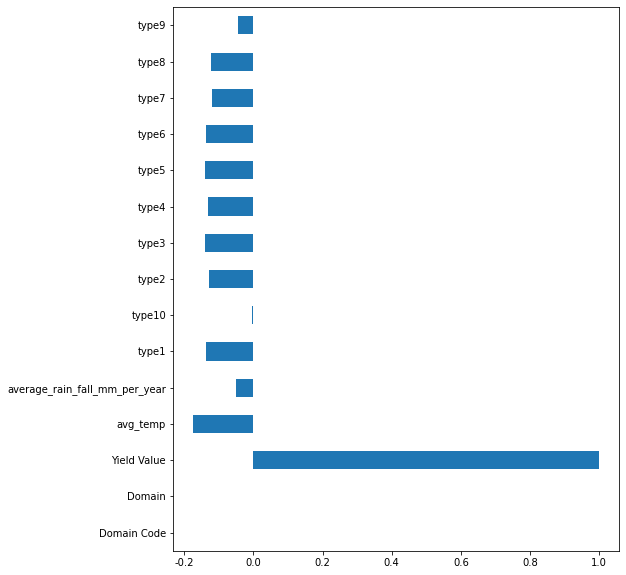

In [143]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei','Times New Roman']

mpl.rcParams['axes.unicode_minus']=False#Negative value display


# correlation between target and features
(dd.corr().loc['Yield Value']     # Calculating the correlation coefficient
.plot(kind='barh', figsize=(8,10)))

In [144]:
X.drop(axis=1,columns=['type10','Domain','Domain Code','type9'],inplace=True)
X.show()

,avg_temp,average_rain_fall_mm_per_year,type1,type2,type3,type4,type5,type6,type7,type8
0,26.25,1756.0,5982079.0,4633037.0,685003.0,71304.0,30295.0,136537.0,2915499.0,23110.0
1,26.19,2277.0,5774329.0,7339414.0,722715.0,66092.0,27633.0,14201.0,4279555.0,17631.0
2,26.55,2257.0,4140497.0,2313189.0,66031.0,146941.0,4665.0,119062.0,7368072.0,8203.0
3,25.96,687.0,2965464.0,2312310.0,787081.0,20593.0,15342.0,78899.0,1450399.0,1780.0
4,25.97,616.0,3464486.0,1074618.0,324716.0,267572.0,29190.0,82875.0,4355657.0,18028.0
...,...,...,...,...,...,...,...,...,...,...
10567,20.52,657.0,3681373.0,3353805.0,472070.0,96556.0,9798.0,98698.0,6784783.0,24226.0
10568,19.76,657.0,5779506.0,4476011.0,400753.0,166308.0,17508.0,86111.0,4672907.0,609.0
10569,25.00,657.0,2087455.0,6814265.0,437980.0,299495.0,3841.0,89233.0,1361238.0,13851.0
10570,1.00,657.0,4071515.0,2604867.0,577870.0,63393.0,4957.0,105440.0,7264470.0,20189.0


In [160]:
values = X.values.tolist()
columns = X.columns.tolist()
X_a = spark.createDataFrame(values, columns)
X_a.show()

+--------+-----------------------------+---------+---------+--------+--------+-------+--------+---------+-------+
|avg_temp|average_rain_fall_mm_per_year|    type1|    type2|   type3|   type4|  type5|   type6|    type7|  type8|
+--------+-----------------------------+---------+---------+--------+--------+-------+--------+---------+-------+
|   26.25|                       1756.0|5982079.0|4633037.0|685003.0| 71304.0|30295.0|136537.0|2915499.0|23110.0|
|   26.19|                       2277.0|5774329.0|7339414.0|722715.0| 66092.0|27633.0| 14201.0|4279555.0|17631.0|
|   26.55|                       2257.0|4140497.0|2313189.0| 66031.0|146941.0| 4665.0|119062.0|7368072.0| 8203.0|
|   25.96|                        687.0|2965464.0|2312310.0|787081.0| 20593.0|15342.0| 78899.0|1450399.0| 1780.0|
|   25.97|                        616.0|3464486.0|1074618.0|324716.0|267572.0|29190.0| 82875.0|4355657.0|18028.0|
|   26.45|                        312.0|5788345.0|4445049.0|410634.0|147896.0|17676.0| 8

In [145]:
print(X.dtypes)

avg_temp                         float64
average_rain_fall_mm_per_year    float64
type1                            float64
type2                            float64
type3                            float64
type4                            float64
type5                            float64
type6                            float64
type7                            float64
type8                            float64
dtype: object


In [146]:
feature_cols = ['temp', 'rainfall', 'plant co2', 'industry co2','ch4','n2O','SF6','hfcs','nf3','pfcs']

In [147]:
_x=dd
_x.drop(axis=1,columns=['type10','Domain','Domain Code','type9',"key4"],inplace=True)
_x

,Yield Value,avg_temp,average_rain_fall_mm_per_year,type1,type2,type3,type4,type5,type6,type7,type8
0,22968.571429,26.25,1756.0,5982079.0,4633037.0,685003.0,71304.0,30295.0,136537.0,2915499.0,23110.0
1,23632.142857,26.19,2277.0,5774329.0,7339414.0,722715.0,66092.0,27633.0,14201.0,4279555.0,17631.0
2,22517.000000,26.55,2257.0,4140497.0,2313189.0,66031.0,146941.0,4665.0,119062.0,7368072.0,8203.0
3,22665.714286,25.96,687.0,2965464.0,2312310.0,787081.0,20593.0,15342.0,78899.0,1450399.0,1780.0
4,22752.714286,25.97,616.0,3464486.0,1074618.0,324716.0,267572.0,29190.0,82875.0,4355657.0,18028.0
...,...,...,...,...,...,...,...,...,...,...,...
10567,39170.750000,20.52,657.0,3681373.0,3353805.0,472070.0,96556.0,9798.0,98698.0,6784783.0,24226.0
10568,37882.750000,19.76,657.0,5779506.0,4476011.0,400753.0,166308.0,17508.0,86111.0,4672907.0,609.0
10569,38196.250000,25.00,657.0,2087455.0,6814265.0,437980.0,299495.0,3841.0,89233.0,1361238.0,13851.0
10570,37217.750000,1.00,657.0,4071515.0,2604867.0,577870.0,63393.0,4957.0,105440.0,7264470.0,20189.0


In [148]:
values = _x.values.tolist()
columns = _x.columns.tolist()
spark_X = spark.createDataFrame(values, columns)
spark_X.show()

+------------------+--------+-----------------------------+---------+---------+--------+--------+-------+--------+---------+-------+
|       Yield Value|avg_temp|average_rain_fall_mm_per_year|    type1|    type2|   type3|   type4|  type5|   type6|    type7|  type8|
+------------------+--------+-----------------------------+---------+---------+--------+--------+-------+--------+---------+-------+
|22968.571428571428|   26.25|                       1756.0|5982079.0|4633037.0|685003.0| 71304.0|30295.0|136537.0|2915499.0|23110.0|
| 23632.14285714286|   26.19|                       2277.0|5774329.0|7339414.0|722715.0| 66092.0|27633.0| 14201.0|4279555.0|17631.0|
|           22517.0|   26.55|                       2257.0|4140497.0|2313189.0| 66031.0|146941.0| 4665.0|119062.0|7368072.0| 8203.0|
|22665.714285714286|   25.96|                        687.0|2965464.0|2312310.0|787081.0| 20593.0|15342.0| 78899.0|1450399.0| 1780.0|
|22752.714285714286|   25.97|                        616.0|3464486.0|

In [149]:
# def fn(item):
#     return (float(item)) 

# fn = udf(fn, IntegerType())
# spark_X = spark_X.withColumn('label', fn('avg_temp'))
# spark_X.show(100)

spark_X=spark_X.withColumnRenamed("Yield Value","label")
spark_X.show(100)

+------------------+--------+-----------------------------+---------+---------+--------+--------+-------+--------+---------+-------+
|             label|avg_temp|average_rain_fall_mm_per_year|    type1|    type2|   type3|   type4|  type5|   type6|    type7|  type8|
+------------------+--------+-----------------------------+---------+---------+--------+--------+-------+--------+---------+-------+
|22968.571428571428|   26.25|                       1756.0|5982079.0|4633037.0|685003.0| 71304.0|30295.0|136537.0|2915499.0|23110.0|
| 23632.14285714286|   26.19|                       2277.0|5774329.0|7339414.0|722715.0| 66092.0|27633.0| 14201.0|4279555.0|17631.0|
|           22517.0|   26.55|                       2257.0|4140497.0|2313189.0| 66031.0|146941.0| 4665.0|119062.0|7368072.0| 8203.0|
|22665.714285714286|   25.96|                        687.0|2965464.0|2312310.0|787081.0| 20593.0|15342.0| 78899.0|1450399.0| 1780.0|
|22752.714285714286|   25.97|                        616.0|3464486.0|

In [150]:
spark_X.printSchema()

root
 |-- label: double (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- average_rain_fall_mm_per_year: double (nullable = true)
 |-- type1: double (nullable = true)
 |-- type2: double (nullable = true)
 |-- type3: double (nullable = true)
 |-- type4: double (nullable = true)
 |-- type5: double (nullable = true)
 |-- type6: double (nullable = true)
 |-- type7: double (nullable = true)
 |-- type8: double (nullable = true)



In [151]:
spark_X.columns

['label',
 'avg_temp',
 'average_rain_fall_mm_per_year',
 'type1',
 'type2',
 'type3',
 'type4',
 'type5',
 'type6',
 'type7',
 'type8']

In [152]:
#spark_X = spark_X.drop("label")
#spark_X.columns

In [153]:
#feature_X=spark_X.columns
feature_X = spark_X.drop("label").columns
feature_X

['avg_temp',
 'average_rain_fall_mm_per_year',
 'type1',
 'type2',
 'type3',
 'type4',
 'type5',
 'type6',
 'type7',
 'type8']

In [154]:
spark_X.columns

['label',
 'avg_temp',
 'average_rain_fall_mm_per_year',
 'type1',
 'type2',
 'type3',
 'type4',
 'type5',
 'type6',
 'type7',
 'type8']

In [155]:
print(spark_X.dtypes)

[('label', 'double'), ('avg_temp', 'double'), ('average_rain_fall_mm_per_year', 'double'), ('type1', 'double'), ('type2', 'double'), ('type3', 'double'), ('type4', 'double'), ('type5', 'double'), ('type6', 'double'), ('type7', 'double'), ('type8', 'double')]


线性回归

In [156]:
#import LinearRegression model
from pyspark.ml.regression import LinearRegression
from pyspark.sql.session import SparkSession

In [157]:
# perform transform to normalize data
from pyspark.ml.feature import StringIndexer,Bucketizer,OneHotEncoder,VectorAssembler
Vector = VectorAssembler(inputCols=feature_X,outputCol="features")
transform_data = Vector.transform(spark_X)

transform_data = transform_data.select("features","label")
#transform_data.select(feature_X).show(truncate=False)
transform_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



In [158]:
transform_data.show()

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[26.25,1756.0,598...|22968.571428571428|
|[26.19,2277.0,577...| 23632.14285714286|
|[26.55,2257.0,414...|           22517.0|
|[25.96,687.0,2965...|22665.714285714286|
|[25.97,616.0,3464...|22752.714285714286|
|[26.45,312.0,5788...|           23694.0|
|[26.05,1371.0,516...|23736.428571428572|
|[26.29,398.0,3649...|23949.571428571428|
|[26.55,2406.0,373...|23590.714285714286|
|[26.51,2269.0,670...|24460.571428571428|
|[26.1,1864.0,5857...|25236.285714285714|
|[26.28,1757.0,794...|24106.714285714286|
|[26.8,1546.0,6121...|24709.428571428572|
|[26.21,376.0,3629...|           25208.0|
|[26.12,2631.0,773...|           29873.0|
|[25.84,223.0,3312...|          25886.75|
|[26.4,1516.0,2825...|          24413.25|
|[26.16,2610.0,789...|         24772.125|
|[26.67,258.0,6645...|           25744.0|
|[26.47,1795.0,344...|           30329.0|
+--------------------+------------

In [159]:

#划分分训练集和测试集，70%数据作为训练集，30%数据作为测试集。
split_data = transform_data.randomSplit([0.7, 0.3])
train_df = split_data[0]
test_df = split_data[1]




## 线性回归

In [91]:
from pyspark.ml.evaluation import RegressionEvaluator
lr=LinearRegression(featuresCol='features',labelCol='label') 
model = lr.fit(train_df)  
model

lr_predictions = model.transform(test_df)

lr_predictions.select('prediction', 'label').show(5)
lr_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("LinearRegression Error (RMSE) on test data = %g" % rmse)

22/10/10 01:46:29 WARN Instrumentation: [fe0261b2] regParam is zero, which might cause numerical instability and overfitting.
22/10/10 01:46:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/10 01:46:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/10 01:46:29 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-----------------+-------+
|       prediction|  label|
+-----------------+-------+
|86734.39748485545|69530.8|
|81723.06277664384|53529.0|
|71881.30709168428|25822.5|
| 82929.3102302197|58589.0|
|76328.15357422947|35769.0|
+-----------------+-------+
only showing top 5 rows

LinearRegression Error (RMSE) on test data = 42163.6


In [92]:
list(zip(feature_cols,model.coefficients))

[('temp', -742.4140113787832),
 ('rainfall', -1.1807856305422162),
 ('plant co2', -0.001064278003554609),
 ('industry co2', -0.0011941337830823418),
 ('ch4', -0.008400268886798658),
 ('n2O', -0.018071147288476464),
 ('SF6', -0.24349517710228166),
 ('hfcs', -0.05792294590680641),
 ('nf3', -0.0007432782963660148),
 ('pfcs', -0.403127774676829)]

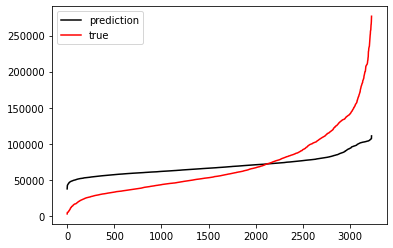

In [93]:
import matplotlib.pyplot as plt 

prediction_li=lr_predictions.select("prediction").toPandas().values.tolist()
label_li=lr_predictions.select("label").toPandas().values.tolist()
plt.plot(range(len(prediction_li)),sorted(prediction_li),c="black",label= "prediction") 
plt.plot(range(len(label_li)),sorted(label_li),c="red",label = "true") 
plt.legend()
plt.show()

## 随机森林算法

In [94]:
# 导入模块

from pyspark.ml.regression import RandomForestRegressor

In [95]:
model_df=transform_data.select(['features','label'])  
model_df.show(20)


+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[26.25,2529.0,554...|22968.571428571428|
|[26.19,1249.0,604...| 23632.14285714286|
|[26.55,3004.0,578...|           22517.0|
|[25.96,1382.0,455...|22665.714285714286|
|[25.97,171.0,1464...|22752.714285714286|
|[26.45,728.0,6321...|           23694.0|
|[26.05,2078.0,541...|23736.428571428572|
|[26.29,3068.0,374...|23949.571428571428|
|[26.55,2572.0,405...|23590.714285714286|
|[26.51,1817.0,461...|24460.571428571428|
|[26.1,2460.0,2824...|25236.285714285714|
|[26.28,1696.0,537...|24106.714285714286|
|[26.8,196.0,59597...|24709.428571428572|
|[26.21,2612.0,459...|           25208.0|
|[26.12,1240.0,969...|           29873.0|
|[25.84,673.0,3558...|          25886.75|
|[26.4,1411.0,2424...|          24413.25|
|[26.16,516.0,6106...|         24772.125|
|[26.67,1527.0,299...|           25744.0|
|[26.47,829.0,2976...|           30329.0|
+--------------------+------------

In [116]:
rf_classifier=RandomForestRegressor(labelCol='label',numTrees=150,maxDepth=5).fit(model_df) 

In [117]:
rf_predictions=rf_classifier.transform(model_df)
rf_predictions.select('prediction', 'label', 'features').show(5)
rf_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("RandomForestRegressor Error (RMSE) on test data = %g" % rmse)

+-----------------+------------------+--------------------+
|       prediction|             label|            features|
+-----------------+------------------+--------------------+
|58355.50551318003|22968.571428571428|[26.25,2529.0,554...|
|58901.59257472519| 23632.14285714286|[26.19,1249.0,604...|
|59359.54906669525|           22517.0|[26.55,3004.0,578...|
|58470.08332334278|22665.714285714286|[25.96,1382.0,455...|
| 76383.2201673162|22752.714285714286|[25.97,171.0,1464...|
+-----------------+------------------+--------------------+
only showing top 5 rows

RandomForestRegressor Error (RMSE) on test data = 38782.5


In [100]:
list(zip(feature_cols,rf_classifier.featureImportances))

[('temp', 0.18493687197575162),
 ('rainfall', 0.12463271877376375),
 ('plant co2', 0.045539941715560306),
 ('industry co2', 0.08713038103307613),
 ('ch4', 0.06238166931637298),
 ('n2O', 0.0770282596311558),
 ('SF6', 0.18867887479233303),
 ('hfcs', 0.06428647651610156),
 ('nf3', 0.07266830441070604),
 ('pfcs', 0.09271650183517888)]

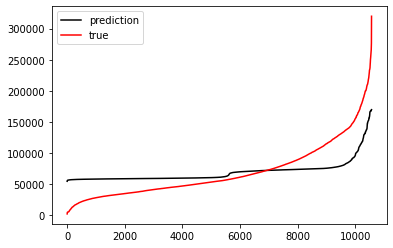

In [101]:
import matplotlib.pyplot as plt 

prediction_li=rf_predictions.select("prediction").toPandas().values.tolist()
label_li=rf_predictions.select("label").toPandas().values.tolist()
plt.plot(range(len(prediction_li)),sorted(prediction_li),c="black",label= "prediction") 
plt.plot(range(len(label_li)),sorted(label_li),c="red",label = "true") 
plt.legend()
plt.show()

## 决策树算法

In [102]:


from pyspark.ml.regression import DecisionTreeRegressor
 

In [103]:
train_df

DataFrame[features: vector, label: double]

In [104]:
from pyspark.ml.regression import DecisionTreeRegressor


dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_predictions.select('prediction', 'label', 'features').show(5)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("DecisionTreeRegressor Error (RMSE) on test data = %g" % rmse)



+------------------+-------+--------------------+
|        prediction|  label|            features|
+------------------+-------+--------------------+
|  98252.2410326087|69530.8|[-4.0,185.0,25825...|
|57588.326773787834|53529.0|[-4.0,254.0,53339...|
|57588.326773787834|25822.5|[-4.0,304.0,49203...|
|57588.326773787834|58589.0|[-4.0,322.0,31168...|
| 74865.68504523809|35769.0|[-4.0,805.0,34841...|
+------------------+-------+--------------------+
only showing top 5 rows

DecisionTreeRegressor Error (RMSE) on test data = 39961.8


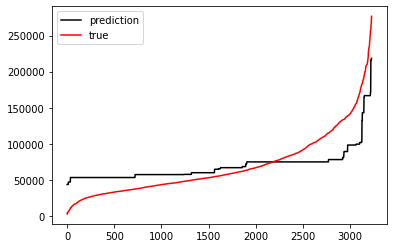

In [105]:
import matplotlib.pyplot as plt 

prediction_li=dt_predictions.select("prediction").toPandas().values.tolist()
label_li=dt_predictions.select("label").toPandas().values.tolist()
plt.plot(range(len(prediction_li)),sorted(prediction_li),c="black",label= "prediction") 
plt.plot(range(len(label_li)),sorted(label_li),c="red",label = "true") 
plt.legend()
plt.show()

## 梯度回归树（GBDT）

In [106]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'label', 'features').show(5)

gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("GBTRegressor Error (RMSE) on test data = %g" % rmse)

+------------------+-------+--------------------+
|        prediction|  label|            features|
+------------------+-------+--------------------+
| 99327.79617417268|69530.8|[-4.0,185.0,25825...|
|58408.029299006055|53529.0|[-4.0,254.0,53339...|
| 56929.80076532729|25822.5|[-4.0,304.0,49203...|
| 58400.18974909262|58589.0|[-4.0,322.0,31168...|
|  71125.2544704037|35769.0|[-4.0,805.0,34841...|
+------------------+-------+--------------------+
only showing top 5 rows

GBTRegressor Error (RMSE) on test data = 39290.6


In [107]:
list(zip(feature_cols,gbt_model.featureImportances))

[('temp', 0.18041053272955482),
 ('rainfall', 0.16837227292569104),
 ('plant co2', 0.08757980605138929),
 ('industry co2', 0.057118077365092876),
 ('ch4', 0.0804200130323536),
 ('n2O', 0.08637968753818215),
 ('SF6', 0.16159928478556126),
 ('hfcs', 0.0519017585497925),
 ('nf3', 0.06924761251627365),
 ('pfcs', 0.05697095450610889)]

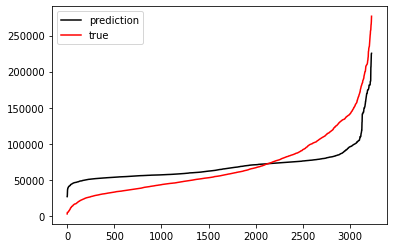

In [108]:
import matplotlib.pyplot as plt 

prediction_li=gbt_predictions.select("prediction").toPandas().values.tolist()
label_li=gbt_predictions.select("label").toPandas().values.tolist()
plt.plot(range(len(prediction_li)),sorted(prediction_li),c="black",label= "prediction") 
plt.plot(range(len(label_li)),sorted(label_li),c="red",label = "true") 
plt.legend()
plt.show()